# General data questions and exploration


In [1]:
### Initialisation ###
import os
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]

EVENT_NAME = Event.objects.all()[0].name.replace(' ', '')
DIR = './data/harvey_user_location/'
DF_FILENAME = 'df_users.csv'
LATEX_DAT_PATH = DIR + 'latex/' + 'harvey-exploration.dat'
LATEX_TABLE_PATH = DIR + 'latex/' + 'harvey-exploration-tabs.dat'

# Confirm correct database is set in Django settings.py
if 'Harvey' not in EVENT_NAME:
    raise Exception('Event name mismatch -- check database set in Django')

for file in [LATEX_DAT_PATH, LATEX_TABLE_PATH]:
    try:    
        os.remove(file)
    except:
        pass

# Open original Dataframe
users_df = pd.read_csv(DIR + DF_FILENAME, index_col=0)
users_df.shape

(1500, 46)

In [2]:
def set_tex_var(name, val, dec=3):
    """
    Define a value as a latex variable to be
    imported into Latex file with (e.g.):
    \input{data/harvey-coding.dat}

    NOTE: does not look for duplicate variable definitions.
    """
    if isinstance(val, float):
        template = r'\newcommand{{\{}}}{{{:,.' + str(dec) + r'f}}}'
    elif isinstance(val, int):
        template = r'\newcommand{{\{}}}{{{:,}}}'
    else:
        template = r'\newcommand{{\{}}}{{{}}}'
    with open(LATEX_DAT_PATH, 'a') as a_writer:
        a_writer.write(template.format(name, val) + '\n')

In [3]:
def sanitise_tex_str(string):
    '''
    Sanitises string for use in Latex
    NOTE: Incomplete
    '''
    string = string.replace('&', '\&')
    string = string.replace('%', '\%')
    return string


def df_to_tex(df, cols=None, label='UNNAMED', caption='UNDEFINED', 
              width=0.8, row_sep=1, col_widths=None, dec_dict=None,
             sum_row=False):
    '''
    Generates a latex table from a dataframe, 
    to be copied by user from output file to tex
    
    NOTE: format columns in the dataframe before passing to func, eg:
        df[col] = df[col].astype(int).map('{:.1f}%'.format)
        df.rename(columns={"A": "a", "B": "c"}, inplace=True)
    NOTE: linewidth and column widths are fixed and require manual adjustment
    
    input: dataframe and desired columns, 
            table reference name and caption text
    output: appends to file LATEX_TABLE_PATH
    returns: none
    '''
    df = df.copy()
    if not cols:
        cols = df.columns
    for col in [x for x in cols if x not in df.columns]:
        df[col] = ''
    df = df[cols]
    
    print('Writing df to file as tex...')
    with open(LATEX_TABLE_PATH, 'a') as a_writer:
        a_writer.write('%<*{}>'.format(label) + '\n')
        a_writer.write('\\begin{table}[H]' + '\n')
        a_writer.write('  \\small\\vspace{5mm}\\centering\\extrarowsep=' + str(row_sep) + 'mm' + '\n')
        if not col_widths:
            col_widths = 'X[-1,lm] ' + ('X[-2,lm] ' * (len(df.columns)-1))
        a_writer.write('  \\begin{tabu} to ' + str(width) + '\\linewidth { '+ col_widths + '}' + '\n')

        # Optionally: limit top rule if first column is unnamed.
#         if cols[0] == '':
#             a_writer.write('    \\cmidrule[1]{{2-{}}}\n'.format(len(cols)))
#         else:
#             a_writer.write('    \\toprule\n')
        a_writer.write('    \\toprule\n')
        
        row_string = '    '
        for col in cols:
            # If last column, add line ending
            if col == df.columns[-1]:
                row_string += col + ' \\\\\n'
            else:
                # Pad to length of longest column value, plus a fixed amount:
                pad = max(df[col].map(str).map(len)) + 4
                if pad - len(col) > 18 or len(col) > pad: # (ignore pad for titles if col vals are long)
                    row_string += (sanitise_tex_str(col) + ' & ')
                else:
                    row_string += (sanitise_tex_str(col).ljust(pad) + '& ')
#                sum([len(x) for x in cols]) + (len(cols)*3) # Ignore pad if col titles exceed text display width ?
        a_writer.write(row_string)
        
        a_writer.write('    \\midrule\n')
        
        for index, row in df.iterrows():
            row_string = '    '
            for col in df.columns:
                if col == df.columns[-1]:
                    if dec_dict and col in dec_dict.keys():
                        try:
                            row_string += (sanitise_tex_str(
                                ('{:.' + str(dec_dict[col]) + 'f}').format(row[col]) 
                            ) + ' \\\\\n')
                        except: # Due to column in percentage format
                            row_string += (sanitise_tex_str(
                                ('{:.' + str(dec_dict[col]) + 'f}%').format(float(row[col].strip('%')))
                            ) + ' \\\\\n')
                    else:
                        row_string += (sanitise_tex_str(str(row[col])) + ' \\\\\n')
                else:
                    pad = max(df[col].map(str).map(len)) + 4
                    if dec_dict and col in dec_dict.keys(): #dec_dict is used to force decimal places with trailing zeroes
                        row_string += (sanitise_tex_str(
                            ('{:.' + str(dec_dict[col]) + 'f}').format(row[col]) 
                        ).ljust(pad) + '& ')
                    else:
                        row_string += (sanitise_tex_str(str(row[col])).ljust(pad) + '& ')
            a_writer.write(row_string)
        
        a_writer.write('    \\bottomrule' + '\n')
        
        # TESTING ########
        if sum_row:
            for col in df.columns:
                try:
                    col_sum = sum(df[col])
                except:
                    try:
                        col_sum = str(sum(df[col].map(lambda x: float(x.strip('%'))))) + '\%'
                    except:
                        col_sum = ''
                if col == df.columns[-1]:
                    a_writer.write(str(col_sum) + ' \\\\\n')
                else:
                    a_writer.write(str(col_sum) + ' & ')
        ################
            
        
        a_writer.write('  \\end{tabu}' + '\n')
        a_writer.write('  \\caption[{}]{{{}}}'.format(caption, caption) + '\n')
        a_writer.write('  \\label{{tab:{}}}'.format(label) + '\n')
        a_writer.write('\\end{table}' + '\n')
        a_writer.write('%</{}>'.format(label) + '\n\n\n')

        return


In [4]:
import pandas as pd
import math
import numpy as np
#from sklearn.metrics import matthews_corrcoef


def confusion_matrix(df: pd.DataFrame, col1: str, col2: str):
    """
    Given a dataframe with at least
    two categorical columns, create a 
    confusion matrix of the count of the columns
    cross-counts
    """
    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )


def confusion_matrix_from_series(s1, s2):
    """
    Returns confusion matrix for two binary
    series
    """
    df = pd.concat([s1, s2], axis=1)
    try:
        return confusion_matrix(df, s1.name, s2.name)
    except:
        return confusion_matrix(df, '', '')


def calc_agreement_coefs(df: pd.DataFrame):
    """
    Calculates Cohen's Kappa and
    Krippendorff's Alpha for a
    given confusion matrix.
    
    NOTE: will error if indicies are integers
    """
    arr = df.to_numpy()
    n = arr.sum()
    p_o = 0
    for i in range(len(arr)):
        p_o += arr[i][i]/n
    p_e = 0
    for i in range(len(arr)):
        p_e += (arr.sum(axis=1)[i] *
                arr.sum(axis=0)[i]) / (n*n)
    kappa = (p_o-p_e)/(1-p_e)
    
    phi_num = (arr[0][0]*arr[1][1]) - (arr[0][1]*arr[1][0])
    a = np.sum(conf, axis=1)
    b = np.sum(conf, axis=0)
    phi_denom = math.sqrt(np.prod([a, b], dtype = np.uint64))
    phi = phi_num/phi_denom
    phi_max = min(
        math.sqrt(a[0] * b[1])/math.sqrt(a[1] * b[0]),
        math.sqrt(a[1] * b[0])/math.sqrt(a[0] * b[1])
        )
    phiphimax = phi/phi_max
    
    coin_arr = np.transpose(arr) + arr
    exp_distribution = [sum(x) for x in coin_arr]
    p_e_krippendorf = sum([a * (a-1) for a in exp_distribution])/(2*n*((2*n)-1))
    alpha = (p_o - p_e_krippendorf) / (1-p_e_krippendorf)
    
    return p_o, kappa, alpha, phi, phiphimax


def calc_agreement_metrics(df: pd.DataFrame):
    """
    Calculates various agreement metrics
    for a given binary confusion matrix.
    
    Assumes true condition as ROW heading and
    ascending integer labels.
    """
    arr = df.to_numpy()
    if len(arr) != 2:
        print('ERROR: df is not 2x2')
        return None
    results = {}
    results['Prevalence'] = arr.sum(axis=0)[1]/arr.sum()
    results['Accuracy'] = (arr[0][0] + arr[1][1])/arr.sum()
    results['Prec'] = arr[1][1]/arr.sum(axis=1)[1]
    results['Recall'] = arr[1][1]/arr.sum(axis=0)[1]
    results['f1Score'] = (2 * results['Prec'] * results['Recall'])/(results['Prec']+results['Recall'])
    results['Specificity'] = arr[0][0]/arr.sum(axis=0)[0]
    results['FalseNegRate'] = arr[0][1]/arr.sum(axis=0)[1]
    p_o, kappa, alpha, phi, phiphimax = calc_agreement_coefs(df)
    results['Cohen\'s Kappa'] = kappa
    results['Krippendorff\'s Alpha'] = alpha
    results['Phi Coef / MCC'] = phi
    results['Phi/PhiMax'] = phiphimax
    
    return results
    

## Data Coding

First, given we are treating the data as binary-coded, we need to be aware of the third code of 'unsure'. In most comparisons, these will automatically be considered as the opposite code from what is being tested. We can instead manually set it to either value, or remove it entirely, given that it comprises a small proportion of the data.

In [5]:
unsure_code = (users_df.is_coded_as_witness == 0) & (users_df.is_coded_as_non_witness == 0)
print(sum(unsure_code), 'cases coded as \'unsure\'')

# Remove 'unsure' rows from data:
#users_df = users_df.loc[unsure_code==False]

# Assign 'unsure' rows to positive coded case:
#users_df.is_coded_as_witness = (users_df.is_coded_as_non_witness == False).astype(int)

# Assign 'unsure' rows to negative coded case:
#users_df.is_coded_as_non_witness = (users_df.is_coded_as_witness == False).astype(int)

31 cases coded as 'unsure'


In [6]:
# Printing Coding Totals
# TODO: output to file and bring into Latex (would need to rename codes), add sum row to bottom of table

cs = Coding.objects.filter(coding_id=1).filter(tweet__isnull=False).filter(data_code__data_code_id__gt=0)
fieldname = 'data_code__data_code_id'
counts = cs.values(fieldname).annotate(count=Count(fieldname))#.order_by('-count')

df = pd.DataFrame.from_dict(counts)
df['Code'] = df[fieldname].map(lambda x: DataCode.objects.get(data_code_id=x).name)
df['Proportion'] = df['count'].map(lambda x: '{:.2f}%'.format(x/sum(df['count'])*100))
df = df.rename(columns={'count':'Tweets'})

df = df.sort_values(by ='data_code__data_code_id' )
df = df[['Code', 'Tweets', 'Proportion']]
df

,Code,Tweets,Proportion
4,Aid Request,35,1.40%
3,Ground Truth,375,15.00%
5,Information for Locals,144,5.76%
1,Information for Non-Locals,577,23.08%
2,Thoughts & Emotion - Local,202,8.08%
0,Thoughts & Emotion - Non-Local,603,24.12%
6,Unrelated,564,22.56%


In [7]:
df_to_tex(df, label='coding-tweets-results', caption='Tweets by Code -- Hurricane Harvey', 
          row_sep=0, col_widths='X[-1,lm] X[-1,rm] X[-1,rm]', dec_dict={'Proportion':1}, sum_row=True)

Writing df to file as tex...


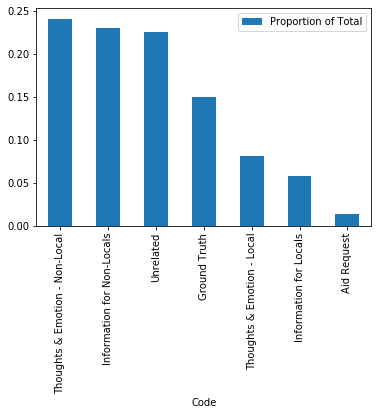

In [8]:
df['Proportion of Total'] = df['Tweets'].map(lambda x: x/sum(df['Tweets']))
df = df.sort_values(by=['Tweets'], ascending=False)
ax = df.plot.bar(x='Code', y='Proportion of Total', rot=90)

fig = ax.get_figure()
fig.savefig(DIR + 'latex/coding-tweets-results.png', bbox_inches='tight')


In [9]:
# Calculate Tweet Coding agreement values and export to tex
# TODO: output conf to latex
codings = Coding.objects.filter(coding_id=2).filter(tweet__isnull=False).filter(data_code__data_code_id__gt=0)

c1 = []
c2 = []
for coding in codings:
    twid = coding.tweet.tweet_id
    c1.append(Coding.objects.filter(coding_id=1).get(tweet__tweet_id=twid).data_code.name)
    c2.append(Coding.objects.filter(coding_id=2).get(tweet__tweet_id=twid).data_code.name)
c1 = pd.Series(c1, name='Coder 1')
c2 = pd.Series(c2, name='Coder 2')
    
conf = confusion_matrix_from_series(c1, c2)
p_o, kappa, alpha, phi, phiphimax = calc_agreement_coefs(conf)

print('Agreement: ', p_o)
print('Alpha: ', alpha)
conf


Agreement:  0.7200000000000001
Alpha:  0.6558993606604212


Coder 2,Aid Request,Ground Truth,Information for Locals,Information for Non-Locals,Thoughts & Emotion - Local,Thoughts & Emotion - Non-Local,Unrelated
Coder 1,,,,,,,
Aid Request,5,0,1,0,0,0,0
Ground Truth,0,33,0,2,0,2,1
Information for Locals,0,0,13,0,0,0,0
Information for Non-Locals,0,7,7,40,1,2,1
Thoughts & Emotion - Local,0,3,0,1,8,3,1
Thoughts & Emotion - Non-Local,1,8,2,7,8,47,0
Unrelated,0,3,2,2,3,2,34


In [10]:
set_tex_var('harveyTwCoded', Coding.objects.filter(coding_id=1).filter(tweet__isnull=False).filter(data_code__data_code_id__gt=0).count())
set_tex_var('harveyTwCodedSecondary', Coding.objects.filter(coding_id=2).filter(tweet__isnull=False).filter(data_code__data_code_id__gt=0).count())
set_tex_var('harveyTwAlpha', alpha, 3)
set_tex_var('harveyTwAgreement', p_o, 3)
set_tex_var('harveyTwKappa', kappa, 3)
if kappa <= 0.2:
    interpretation = 'none to slight agreement'
elif kappa <= 0.4:
    interpretation = 'fair agreement'
elif kappa <= 0.6:
    interpretation = 'moderate agreement'
elif kappa <= 0.8:
    interpretation = 'substantial agreement'
elif kappa < 1:
    interpretation = 'almost perfect agreement'
else:
    interpretation = 'perfect agreement'
set_tex_var('harveyTwKappaInterpretation', interpretation)
set_tex_var('hrvTwHighVal', sum(df[df['Code'].isin(['Ground Truth', 'Aid Request'])]['Proportion of Total'])*100, 1)

In [11]:
#TODO: 
#For example, while the primary coder disagrees with 16.7\% of the messages which the secondary coder classified as `Aid Requests', 
# and 15.4\% of their `Thoughts \& Emotion -- Non-Local', 
# the former represents a single message, whereas the latter comprises 8 instances of disagreement.

In [12]:
# Printing Coding Totals

cs = Coding.objects.filter(coding_id=1).filter(user__isnull=False).filter(data_code__data_code_id__gt=0)
fieldname = 'data_code__data_code_id'
counts = cs.values(fieldname).annotate(count=Count(fieldname))

df = pd.DataFrame.from_dict(counts)
df['Code'] = df[fieldname].map(lambda x: DataCode.objects.get(data_code_id=x).name)
df['Proportion'] = df['count'].map(lambda x: '{:.1f}%'.format(x/sum(df['count'])*100))
df = df.rename(columns={'count':'Users'})

df = df.iloc[::-1][['Code', 'Users', 'Proportion']]
df

,Code,Users,Proportion
2,Witness,386,25.7%
1,Non-Witness,1083,72.2%
0,Unsure,31,2.1%


In [13]:
df_to_tex(df, label='coding-users-results', caption='Users by Code -- Hurricane Harvey', width=0.6,
          row_sep=0, col_widths='X[-1,lm] X[-1,rm] X[-1,rm]', dec_dict={'Proportion':1}, sum_row=True)

# TODO: print other variables to Latex .dat

Writing df to file as tex...


In [14]:
# Calculate Coding agreement values and export to tex

codings = Coding.objects.filter(coding_id=2).filter(user__isnull=False).filter(data_code__data_code_id__gt=0)#.values('user_id')

c1 = []
c2 = []
for coding in codings:
    usid = coding.user.user_id
    c1.append(Coding.objects.filter(coding_id=1).get(user__user_id=usid).data_code.name)
    c2.append(Coding.objects.filter(coding_id=2).get(user__user_id=usid).data_code.name)
c1 = pd.Series(c1, name='Coder 1')
c2 = pd.Series(c2, name='Coder 2')
    
conf = confusion_matrix_from_series(c1, c2)
order = ['Witness', 'Non-Witness', 'Unsure']
conf = conf[order].reindex(order)

p_o, kappa, alpha, phi, phiphimax = calc_agreement_coefs(conf)


print('Agreement: ', p_o)
print('Alpha: ', alpha)
conf


Agreement:  0.835
Alpha:  0.6736722099680289


Coder 2,Witness,Non-Witness,Unsure
Coder 1,,,
Witness,60,5,0
Non-Witness,14,107,8
Unsure,6,0,0


In [15]:
set_tex_var('harveyUsCoded', Coding.objects.filter(coding_id=1).filter(user__isnull=False).filter(data_code__data_code_id__gt=0).count())
set_tex_var('harveyUsCodedSecondary', Coding.objects.filter(coding_id=2).filter(user__isnull=False).filter(data_code__data_code_id__gt=0).count())
set_tex_var('harveyUsAlpha', alpha, 3)
set_tex_var('harveyUsAgreement', p_o, 3)
set_tex_var('harveyUsKappa', kappa, 3)
if kappa <= 0.2:
    interpretation = 'none to slight agreement'
elif kappa <= 0.4:
    interpretation = 'fair agreement'
elif kappa <= 0.6:
    interpretation = 'moderate agreement'
elif kappa <= 0.8:
    interpretation = 'substantial agreement'
elif kappa < 1:
    interpretation = 'almost perfect agreement'
else:
    interpretation = 'perfect agreement'
set_tex_var('harveyUsKappaInterpretation', interpretation)

## Comparison of Codes and Ground Truth Data
Manual coding of users targetted the perceived locality of the user to the event. We can compare the geographic metadata provided by Twitter to these codes to determine their usefulness as a predictor for this value.

### Profile Location Field
The first value to check is the location of a user as set in their profile. This is a user-set string. In an earlier notebook, this string was geocoded using Google Maps api and evaluated for whether it fell within the bounding box defined for this event. We can therefore check whether this test correlates with the coded value.

First, we check what proportion of users provide a value in the field. We can then generate a confusion matrix showing the agreement between the profile locality where provided, and the coded value.

In [16]:
us = User.objects.filter(user_class__gt=0)
#us = us.filter(coding_for_user__coding_id=1, coding_for_user__data_code__data_code_id__gt=0)
tot = us.count()
tot_loc = us.count() - (us.filter(location="") | us.filter(location__isnull=True)).count()

print('Total users: ', tot)
print('Total users with location filled: ', tot_loc)
print('Proportion: {:.4}%'.format((tot_loc/tot)*100))

print('\nProportion of coded users with location filled: {:.4}%'.format((sum(users_df.location.notna())/users_df.shape[0])*100))

print('\nProportion of coded users with parseable location filled: {:.4}%'.format(
    (users_df.loc[(users_df.is_non_local_profile_location + users_df.is_local_profile_location) > 0].shape[0]/users_df.shape[0])*100))

Total users:  31932
Total users with location filled:  25619
Proportion: 80.23%

Proportion of coded users with location filled: 79.4%

Proportion of coded users with parseable location filled: 77.47%


In [17]:
set_tex_var('hrvUsTotal', tot)
set_tex_var('hrvUsTotalLoc', tot_loc)
set_tex_var('hrvUsTotalLocPrp', (tot_loc/tot)*100, 1)
set_tex_var('hrvUsCodedLoc', sum(users_df.location.notna()))
set_tex_var('hrvUsCodedLocPrp', (sum(users_df.location.notna())/users_df.shape[0])*100, 1)
set_tex_var('hrvUsCodedNoLocPrp', (1-sum(users_df.location.notna())/users_df.shape[0])*100, 1)

In [18]:
dft = users_df.loc[users_df.location.notna()]
non_nulls = sum(dft['is_non_local_profile_location']+dft['is_local_profile_location'])

null_returns = dft.shape[0] - non_nulls
null_returns_prop = null_returns/dft.shape[0]*100

print('{} of {} ({:.2f}%) profile locations returned as null'.format(null_returns, dft.shape[0], null_returns_prop))

29 of 1191 (2.43%) profile locations returned as null


In [19]:
set_tex_var('hrvUsPrfLocUnparsable', null_returns)
set_tex_var('hrvUsPrfLocUnparsablePrp', null_returns_prop, 1)

In [20]:
vals = users_df.loc[users_df["is_local_profile_location"] == 1]["is_coded_as_witness"].value_counts()
vals2 = users_df.loc[users_df["is_coded_as_witness"] == 1]["is_local_profile_location"].value_counts()

print('{} of {} ({:.4}%) users were classified as having a local profile'.format(sum(vals), len(users_df), sum(vals)/len(users_df)*100))
print('{} of {} ({:.4}%) users were coded as a witness'.format(sum(vals2), len(users_df), sum(vals2)/len(users_df)*100))
print('{} of {} ({:.4}%) users with local profile locations were coded as witness'.format(vals[1], sum(vals), vals[1]/sum(vals)*100))
print('{} of {} ({:.4}%) witness codes had a local profile'.format(vals2[1], sum(vals2), vals2[1]/sum(vals2)*100))

397 of 1500 (26.47%) users were classified as having a local profile
386 of 1500 (25.73%) users were coded as a witness
258 of 397 (64.99%) users with local profile locations were coded as witness
258 of 386 (66.84%) witness codes had a local profile


In [21]:
# We exclude rows where either no profile location field was provided, 
# or the location was not parsed by the API:
loc_df = users_df.loc[(users_df.is_non_local_profile_location + users_df.is_local_profile_location) > 0]
print(users_df.shape[0] - loc_df.shape[0], 'rows with no parseable profile location value excluded')

conf = confusion_matrix(loc_df, 'is_local_profile_location', 'is_coded_as_witness')
conf

338 rows with no parseable profile location value excluded


is_coded_as_witness,0,1
is_local_profile_location,,
0,695,70
1,139,258


In [22]:
results = calc_agreement_metrics(conf)
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['loc_prof_nona'])
res_df

,loc_prof_nona
Prevalence,0.282272
Accuracy,0.820138
Prec,0.649874
Recall,0.786585
f1Score,0.711724
Specificity,0.833333
FalseNegRate,0.213415
Cohen's Kappa,0.582731
Krippendorff's Alpha,0.581198
Phi Coef / MCC,0.588340


In [23]:
set_tex_var('proflocconfa', conf[0][0])
set_tex_var('proflocconfb', conf[1][0])
set_tex_var('proflocconfc', conf[0][1])
set_tex_var('proflocconfd', conf[1][1])
set_tex_var('hrvUsLocPrfAgr', res_df.loc['Accuracy'][0], 3)
set_tex_var('hrvUsLocPrfAlpha', res_df.loc['Krippendorff\'s Alpha'][0], 3)
set_tex_var('hrvUsLocPrfFsc', res_df.loc['f1Score'][0], 3)
set_tex_var('hrvUsLocPrfPrc', res_df.loc['Prec'][0], 3)
set_tex_var('hrvUsLocPrfRc', res_df.loc['Recall'][0], 3)

As excluding the ~20% of values with no parseable location field provided is not an option in practice, we must decide to either discard them (i.e. by default classify as non-local) or include them (default classify as local). The first option will inevitable discard true positive cases, thus reducing recall, whereas the latter will introduce false positives, reducing precision:

In [24]:
conf = confusion_matrix(users_df, 'is_local_profile_location', 'is_coded_as_witness')
print('loc_prof_notna')
print(conf)
res_df['loc_prof_notna'] = calc_agreement_metrics(conf).values()


conf = confusion_matrix_from_series(
    pd.Series(
                (users_df.is_local_profile_location) | (users_df.location.isna()).astype(int), 
                name='is_local_profile_location_or_na'
             ),
    users_df.is_coded_as_witness)
print('\nloc_prof_orna')
print(conf)
res_df['loc_prof_orna'] = calc_agreement_metrics(conf).values()


res_df

loc_prof_notna
is_coded_as_witness          0    1
is_local_profile_location          
0                          975  128
1                          139  258

loc_prof_orna
is_coded_as_witness                0    1
is_local_profile_location_or_na          
0                                714   80
1                                400  306


,loc_prof_nona,loc_prof_notna,loc_prof_orna
Prevalence,0.282272,0.257333,0.257333
Accuracy,0.820138,0.822000,0.680000
Prec,0.649874,0.649874,0.433428
Recall,0.786585,0.668394,0.792746
f1Score,0.711724,0.659004,0.560440
Specificity,0.833333,0.875224,0.640934
FalseNegRate,0.213415,0.331606,0.207254
Cohen's Kappa,0.582731,0.538603,0.341243
Krippendorff's Alpha,0.581198,0.538725,0.309098
Phi Coef / MCC,0.588340,0.538700,0.379833


In [25]:
set_tex_var('hrvUsLocPrfFscB', res_df.loc['f1Score']['loc_prof_notna'], 3)
set_tex_var('hrvUsLocPrfPrcB', res_df.loc['Prec']['loc_prof_notna'], 3)
set_tex_var('hrvUsLocPrfRcB', res_df.loc['Recall']['loc_prof_notna'], 3)

set_tex_var('hrvUsLocPrfFscC', res_df.loc['f1Score']['loc_prof_orna'], 3)
set_tex_var('hrvUsLocPrfPrcC', res_df.loc['Prec']['loc_prof_orna'], 3)
set_tex_var('hrvUsLocPrfRcC', res_df.loc['Recall']['loc_prof_orna'], 3)

The results above are as expected. Excluding empty fields gives a precision/recall of 0.650/0.668 whereas exluding them gives 0.433/0.793. The exclusion strategy provides the highest f1 score, however given the purpose of the algorithm must be considered when choosing how to weight precision and recall metrics. For example, given the algorithm is designed to curate the feed for human consumption, a high precision is only necessary if the rate of positive cases exceeds the humans' ability to parse the incoming stream. Where the rate is low, sacrificing precision is acceptable to present the human user with more cases which they can then manually filter. 

This concept will be explored in more depth later in the project. For now, it is sufficient to note the values as a baseline model.

### Tweet Stream Coordinates
When posting a Tweet, a user may attach geographic coordinates. The location of the device is provided by the hardware and automatically included with the Tweet (thus the user does not influence the input). A Tweet may also include, instead of specific coordinates, a 'Place' object -- a geographic region (defined by Twitter) which typically describes a location such as a city, state or other similarly-sized region.

To geolocate a user, we can therefore investigate their Twitter feed for any Tweets containing this geographic data and compare these to the bounding box of the observed event. The derived field therefore represents whether *any* of a user's Tweets were identified as 'local' during the event.

For this dataset, the Twitter feed for each observed user spanning the duration of the collection period was collected at the end of the collection period. The feed is therefore made up of Tweets detected during the collection period, and any other Tweets the user made during the period, before or after the detected Tweet, provided they existed at the end of the collection period.

Further work on this area should consider the following:
* Where a local Tweet has been detected, check the proportion of other Tweets containing geographic data.
* Where other geo-Tweets exist, check whether they are from the same point or move around -- consider recoding for where a user Tweets from within *and* without the bounding box.
* Where all geo-Tweets come from the same point, it is likely that location has been manually set (i.e. it is a storefront/business account). This may be verifiable by checking the Tweet source.

In [26]:
# Check proportion of non-stream Tweets which included coordinates:
# Note that given many streams come from geo-detected users, this number may
# over-report general incidence. Removing these Tweets returned a value of 0.5%,
# though this underreports.

with_geotag = Tweet.objects.filter(data_source__lt=1).filter(coordinates_lat__isnull=False).count()
without_geotag = Tweet.objects.filter(data_source__lt=1).filter(coordinates_lat__isnull=True).count()
prop = (with_geotag/(with_geotag+without_geotag))*100

print('{:.1f}% of non-streamed Tweets include geotag'.format(prop))
set_tex_var('hrvTwGeotagPrp', prop, 1)

# Recalculate excluding all geo stream users:
# geo_users = set([tw.author.user_id for tw in Tweet.objects.filter(data_source=3)])
# ts = Tweet.objects.filter(data_source__lt=1).exclude(author__user_id__in=geo_users)
# with_geotag = ts.filter(coordinates_lat__isnull=False).count()
# without_geotag = ts.filter(coordinates_lat__isnull=True).count()
# prop = (with_geotag/(with_geotag+without_geotag))*100
# print('{:.1f}% of non-streamed Tweets include geotag'.format(prop))

1.6% of non-streamed Tweets include geotag


In [27]:
local_tweet = sum(users_df['has_tweet_from_locality'])
prop = local_tweet / users_df.shape[0]*100
print('{} of {} ({:.1f}%) users had a Tweet from local region'.format(local_tweet, users_df.shape[0], prop))

set_tex_var('hrvUsLocalTw', local_tweet)
set_tex_var('hrvUsLocalTwPrp', prop, 1)

467 of 1500 (31.1%) users had a Tweet from local region


In [28]:
conf = confusion_matrix(users_df, 'has_tweet_from_locality', 'is_coded_as_witness')
print('has_tweet_from_locality')
print(conf)

metrics = calc_agreement_metrics(conf)

# metrics['Prec']
# metrics['Recall']
# metrics['f1Score']

dft = pd.DataFrame([['Precision', metrics['Prec']], ['Recall', metrics['Recall']], ['$F_1$ Score', metrics['f1Score']]],
                  columns=['', 'Tweet from Local Region'])

df_to_tex(dft, label='tw-loc-compar', caption='Tweet from Local Region as Locality Predictor', 
          row_sep=0, width=0.4, col_widths='X[-1,lm] X[-2,rm]', dec_dict={'Tweet from Local Region':3})

has_tweet_from_locality
is_coded_as_witness        0    1
has_tweet_from_locality          
0                        898  135
1                        216  251
Writing df to file as tex...


In [29]:
res_df['local_tw'] = metrics.values()
res_df

,loc_prof_nona,loc_prof_notna,loc_prof_orna,local_tw
Prevalence,0.282272,0.257333,0.257333,0.257333
Accuracy,0.820138,0.822000,0.680000,0.766000
Prec,0.649874,0.649874,0.433428,0.537473
Recall,0.786585,0.668394,0.792746,0.650259
f1Score,0.711724,0.659004,0.560440,0.588511
Specificity,0.833333,0.875224,0.640934,0.806104
FalseNegRate,0.213415,0.331606,0.207254,0.349741
Cohen's Kappa,0.582731,0.538603,0.341243,0.427080
Krippendorff's Alpha,0.581198,0.538725,0.309098,0.425219
Phi Coef / MCC,0.588340,0.538700,0.379833,0.430862


While the recall of this metric is close (slightly less than) `loc_prof_notna`, there is no increase in precision and thus it is an inferior metric to predict the true condition.

We can however check whether the metric is capturing a different proportion of local users, and therefore improve upon the existing measures through combination. Using an OR condition will increase recall at the cost of precision; using an AND condition will increase precision at the cost of recall.

In [30]:
conf = confusion_matrix(users_df, 'has_tweet_from_locality', 'is_coded_as_witness')
conf

is_coded_as_witness,0,1
has_tweet_from_locality,,
0,898,135
1,216,251


In [31]:
conf = confusion_matrix_from_series(
    pd.Series(
        ((users_df.is_local_profile_location) | (users_df.has_tweet_from_locality)),
        name = 'is_local_profile_location_or_local_tw'
        ),
    users_df.is_coded_as_witness)
# conf

res_df['loc_prof_notna_or_loc_tw'] = calc_agreement_metrics(conf).values()

conf = confusion_matrix_from_series(
    pd.Series(
        ((users_df.is_local_profile_location) & (users_df.has_tweet_from_locality)),
        name = 'is_local_profile_location_and_local_tw'
        ),
    users_df.is_coded_as_witness)
# conf

res_df['loc_prof_notna_and_loc_tw'] = calc_agreement_metrics(conf).values()

res_df

,loc_prof_nona,loc_prof_notna,loc_prof_orna,local_tw,loc_prof_notna_or_loc_tw,loc_prof_notna_and_loc_tw
Prevalence,0.282272,0.257333,0.257333,0.257333,0.257333,0.257333
Accuracy,0.820138,0.822000,0.680000,0.766000,0.788000,0.800000
Prec,0.649874,0.649874,0.433428,0.537473,0.558219,0.653571
Recall,0.786585,0.668394,0.792746,0.650259,0.844560,0.474093
f1Score,0.711724,0.659004,0.560440,0.588511,0.672165,0.549550
Specificity,0.833333,0.875224,0.640934,0.806104,0.768402,0.912926
FalseNegRate,0.213415,0.331606,0.207254,0.349741,0.155440,0.525907
Cohen's Kappa,0.582731,0.538603,0.341243,0.427080,0.524972,0.425170
Krippendorff's Alpha,0.581198,0.538725,0.309098,0.425219,0.515676,0.421208
Phi Coef / MCC,0.588340,0.538700,0.379833,0.430862,0.549560,0.434221


In [32]:
cols = ['loc_prof_notna', 'local_tw', 'loc_prof_notna_and_loc_tw', 'loc_prof_notna_or_loc_tw']

dft = res_df.loc[res_df.index.isin(['Prec', 'Recall', 'f1Score'])][cols]
dft = dft.reset_index()
dft.columns = ['', 'Local Profile', 'Local Tweet', 'Local Profile $\cap$ Local Tweet', 'Local Profile $\cup$ Local Tweet']
dft[''] = pd.Series(['Precision', 'Recall', '$F_1$ Score'])
dft

,,Local Profile,Local Tweet,Local Profile $\cap$ Local Tweet,Local Profile $\cup$ Local Tweet
0,Precision,0.649874,0.537473,0.653571,0.558219
1,Recall,0.668394,0.650259,0.474093,0.844560
2,$F_1$ Score,0.659004,0.588511,0.549550,0.672165


In [33]:
dec_dict = {k:3 for k in dft.columns[1:]}
df_to_tex(dft, label='composite-loc-compar', caption='Comparison of Composite Predictors', 
          row_sep=0, col_widths='X[-2,lm] X[-1,rm] X[-1,rm] X[-1,rm] X[-1,rm]', dec_dict = dec_dict)

set_tex_var('hrvUsLocPrfUnionPrc', dft['Local Profile $\cup$ Local Tweet'][0],  3)
set_tex_var('hrvUsLocPrfUnionRc', dft['Local Profile $\cup$ Local Tweet'][1],  3)

Writing df to file as tex...


As we can see from the table above, the highest precision is observed from the classifier `loc_prof_notna_and_loc_tw` at 0.656 (though at a great cost to recall). It should be noted that selecting for cases which satisfy both conditions may inadvertently select for a particular (as-yet unidentified) sub-category of user type and exclude other categories of value. The highest fscore comes from `loc_prof_notna_or_loc_tw` at 0.672, which has a precision of 0.558.

While the low scores of these metrics show that they cannot provide meaningful proxies for the manually assigned code, as classifiers they provide a suitable baseline from which to measure more sophisticated models.

## Tweet Source
An important distinguishing metadatum of a Tweet is the 'source' field, which represents the platform from which the Tweet was published. When creating a third-party application which can interact with the Twitter API, a developer must provide a descriptor string which populates this field. Because many third-party applications are designed for specific use-cases, this field provides useful information which characterises the motivations for conditions under which the Tweet was created. For example, the source `TweetMyJOBS` refers to a recruitment platform and thus is attached to Tweets advertising job listings.

We can look at the list of most common source from within the entire dataset and compare this to the sources detected during the collection period. (Note that the complete dataset will still contain a selection bias and does not necessarily characterise regular Twitter use)

In [34]:
# View most common sources from entire dataset:
from django.db.models import Count
from streamcollect.models import Tweet

ts = Tweet.objects.all()

fieldname = 'source'
counts = ts.values(fieldname).order_by(fieldname).annotate(count=Count(fieldname)).order_by('-count')

dft = pd.DataFrame.from_dict(counts[:10])
dft['Proportion'] = (dft['count'].astype(int) / ts.count()*100).map('{:.1f}%'.format)

# Title case for columns:
dft.rename(columns={x: x.title() for x in dft.columns}, inplace=True)

print('Total Tweets:', ts.count())
dft

Total Tweets: 1727438


,Count,Source,Proportion
0,535558,Twitter for iPhone,31.0%
1,348743,Twitter for Android,20.2%
2,342908,Twitter Web Client,19.9%
3,95360,IFTTT,5.5%
4,45830,Twitter for iPad,2.7%
5,43808,Twitter Lite,2.5%
6,42045,Instagram,2.4%
7,32273,TweetDeck,1.9%
8,28536,Facebook,1.7%
9,27105,Hootsuite,1.6%


In [35]:
# Adding descriptions for latex table, based on manual inspection and classification:
descs = [
    'first-party', 'first-party', 'first-party', 'automated process, crossposting', 'first-party',
    'first-party', 'third-party crossposting', 'first-party', 'third-party crossposting', 'social media manager'
]
dft['Description'] = pd.Series(descs)

df_to_tex(dft, cols=['Proportion', 'Source', 'Description'], label='top-tw-sources', caption='Top 10 Tweet Sources')

Writing df to file as tex...


In [36]:
# Count proportion of Tweets from first-party applications
first_party_sources = [
    'Twitter for iPhone',
    'Twitter for Android',
    'Twitter Web Client',
    'Twitter for iPad',
    'Twitter Lite',
    'TweetDeck',
    'Twitter for Windows',
    'Twitter for Mac',
    'Twitter for Windows Phone',
    'Twitter for BlackBerry',
    'Twitter for Android Tablets',
    'Twitter MMS'
    ]
fp_count = 0
for x in counts:
    if any([y in x['source'] for y in first_party_sources ]):
        fp_count += x['count']
print('{:.1f}% of total from first party clients: {}'.format((fp_count/ts.count()*100), fp_count))

78.5% of total from first party clients: 1355569


In [37]:
# Write to Latex variable
set_tex_var('hrvTwTotal', ts.count())
set_tex_var('hrvTwFP', fp_count)
set_tex_var('hrvTwFPPrp', fp_count/ts.count()*100, 1)

In [38]:
ts = Tweet.objects.filter(data_source=1)
print('Total for data_source=1 (keyword stream):', ts.count())

fieldname = 'source'
counts = ts.values(fieldname).order_by(fieldname).annotate(count=Count(fieldname)).order_by('-count')

dft = pd.DataFrame.from_dict(counts[:10])
dft['Proportion'] = (dft['count'].astype(int) / ts.count()*100).map('{:.1f}%'.format)

# Title case for columns:
dft.rename(columns={x: x.title() for x in dft.columns}, inplace=True)

dft

Total for data_source=1 (keyword stream): 31303


,Count,Source,Proportion
0,8959,Twitter for iPhone,28.6%
1,7989,Twitter Web Client,25.5%
2,5086,Twitter for Android,16.2%
3,1754,Paper.li,5.6%
4,981,Hootsuite,3.1%
5,733,Instagram,2.3%
6,720,IFTTT,2.3%
7,682,Facebook,2.2%
8,658,TweetDeck,2.1%
9,652,Twitter for iPad,2.1%


In [39]:
ts = Tweet.objects.filter(data_source__gt=1, coordinates_lat__isnull=False)
print('Total for data_source=3 (geo stream)', ts.count())

fieldname = 'source'
counts = ts.values(fieldname).order_by(fieldname).annotate(count=Count(fieldname)).order_by('-count')

dft = pd.DataFrame.from_dict(counts[:10])
dft['Proportion'] = (dft['count'].astype(int) / ts.count()*100).map('{:.1f}%'.format)

# Title case for columns:
dft.rename(columns={x: x.title() for x in dft.columns}, inplace=True)

dft

Total for data_source=3 (geo stream) 15569


,Count,Source,Proportion
0,11922,Instagram,76.6%
1,1020,TweetMyJOBS,6.6%
2,928,SafeTweet by TweetMyJOBS,6.0%
3,602,BubbleLife,3.9%
4,267,Foursquare,1.7%
5,234,Untappd,1.5%
6,129,Twitter for Android,0.8%
7,104,Hootsuite,0.7%
8,87,Twitter for iPhone,0.6%
9,55,circlepix,0.4%


In [40]:
# Adding descriptions for latex table, based on manual inspection and classification:
descs = [
    'third-party crossposting', 'job listings', 'job listings', 'social media manager', 'check-in app, crossposting',
    'check-in app, crossposting', 'first-party', 'social media manager', 'first-party', 'real estate listings'
    ]
dft['Description'] = pd.Series(descs)

df_to_tex(dft, cols=['Proportion', 'Source', 'Description'], label='top-tw-sources-geo', caption='Top 10 Tweet Sources -- Geographic Stream')

Writing df to file as tex...


In [41]:
fp_count = 0
for x in counts:
    if any([y in x['source'] for y in first_party_sources ]):
        fp_count += x['count']
print('{:.1f}% of geo stream from first party clients: {}'.format((fp_count/ts.count()*100), fp_count))

1.7% of geo stream from first party clients: 259


In [42]:
set_tex_var('hrvTwGeoTotal', ts.count())
set_tex_var('hrvTwGeoFP', fp_count)
set_tex_var('hrvTwGeoFPPrp', fp_count/ts.count()*100, 1)

val = ts.filter(source='Instagram').count()
set_tex_var('hrvTwGeoInsta', val)
set_tex_var('hrvTwGeoInstaPrp', val/ts.count()*100, 1)

val = ts.filter(source__contains='TweetMyJOBS').count()
set_tex_var('hrvTwGeoJobs', val)
set_tex_var('hrvTwGeoJobsPrp', val/ts.count()*100, 1)

Of the entire dataset of 1,727,438 Tweets, those published by first-party Twitter clients comprised 78.5% (1,355,569). In contrast, of the subset of 15,630 Tweets collected based on their location within the event's bounding box, only 1.7% (262) were published from first-party apps. Tweets crossposted by Instagram comprised 76.6% of the geotagged Tweets. The high incidence of Instagram posts in the geographic stream therefore suggest that Instagram posts are much more likely than Tweets to include geographic data, which is preserved during the crossposting process. We can check the rate across the entire dataset excluding the geo stream:

In [43]:
ts = Tweet.objects.filter(source='Instagram', data_source__lt=3)
print('Total Instagram Tweets (excl. geo stream):', ts.count())
ts_geo = ts.filter(coordinates_lat__isnull=False)
print('Total geotagged Instagram Tweets: {}, {:.1f}%'.format(ts_geo.count(), ts_geo.count()/ts.count()*100 ))

Total Instagram Tweets (excl. geo stream): 30123
Total geotagged Instagram Tweets: 9818, 32.6%


In [44]:
set_tex_var('hrvTwInstaTotalNongeo', ts.count())
set_tex_var('hrvTwInstaGeotagNongeo', ts_geo.count())
set_tex_var('hrvTwInstaGeotagNongeoPrp', ts_geo.count()/ts.count()*100, 1)

In [45]:
ts = Tweet.objects.filter(source__contains='TweetMyJOBS')
print('Total TweetMyJOBS Tweets:', ts.count())
ts_geo = ts.filter(coordinates_lat__isnull=False)
print('Total geotagged TweetMyJOBS Tweets: {}, {:.1f}%'.format(ts_geo.count(), ts_geo.count()/ts.count()*100 ))

Total TweetMyJOBS Tweets: 18517
Total geotagged TweetMyJOBS Tweets: 17150, 92.6%


In [46]:
set_tex_var('hrvTwJobsTotal', ts.count())
set_tex_var('hrvTwJobsGeotag', ts_geo.count())
set_tex_var('hrvTwJobsGeotagPrp', ts_geo.count()/ts.count()*100, 1)

As Instagram posts are traditionally based upon the publication of a recently-taken photo, the high incidence of geotagging makes this class of message highly useful in supporting the development of situational awareness.

Tweets were inspected by category (see code below) to classify the general use-case of each source and eliminate those which were only used for automated/unrelated purposes:

In [47]:
# Investigate Tweets by source to characterise source content:
# (samples are not limited to data_source>0)

ts = Tweet.objects.filter(data_source__gte=1)
fieldname = 'source'
counts = ts.values(fieldname).order_by(fieldname).annotate(count=Count(fieldname)).order_by('-count')
source_list = [x['source'] for x in counts if x['count'] > 10]

for source in source_list:
    print('__________________\n{}:\n'.format(source))
    ts = Tweet.objects.filter(source=source)
    for t in ts.order_by('?')[:15]:
#     for t in ts.filter(data_source__gte=1).order_by('?')[:15]: # To only sample detected Tweets
        print(t.text.replace('\n', ''))

__________________
Instagram:

I'm waaaay up, I feel blessed 🙏🏽 to work with an amazing group of Boss Babes. #teamLB… https://t.co/bMjN3ElYuh
Hurricane Harvey @ Houston, Texas https://t.co/8TAvXrpE3f
#PrayForHouston And Spring... Push Me To The Edge Not Over... #FollowTheSmell🙏💦🍜🔥💯 @ Houston,… https://t.co/SUVA8fMuZI
Just posted a video @ Westside, Houston, Texas https://t.co/6KPJQU3lWJ
"One person decides that we're unfit for service, or that we cost too much, when there are so… https://t.co/GznSFT8ktv
El chamaquito en acción https://t.co/RSCLlcfweb
This may hurt some but it's the truth.#HardTruth #Facts#BeReal https://t.co/9h7xcJqCzy
Nuff said#cannibalox #hiphop#thatisntgay @ Riverside, San Antonio https://t.co/O5DaZHSIBk
Out for a drive. Water is still high but has receded a bit. @ Bay… https://t.co/Umg2qMUE7t
Urgent!! I have a goal to meet by tonight and need your help! I'm looking for 5 more people to… https://t.co/3RJKdVHTsv
enmivida thinking of you my dear friend @ Czech Stop an

My latest on @HuffPost On Reinfibulation: Part of the #FGM Discussion that Rarely Gets Mentioned. https://t.co/51hMiEmYVP
Be Prepared! Recovery After an Outage https://t.co/Au732cMDb8 #HurricaneHarvey
Premios Tu Mundo 2017: Lista completa de ganadores #PremiosTuMundo https://t.co/hRtnL3sfbx https://t.co/s3GbenKVhC
RT @FundThePeople: Happy Monday. What can u do this week 2 sppt equity + inclusion in your .org or the #nonprofit sector? https://t.co/tUMV…
@dino_grandoni Electric co-op linemen work to restore power near Victoria, TX. #HurricaneHarvey Credit: Victoria Electric Cooperative https://t.co/GO6q5ikxrr
Effective #suicideprevention for troops (everyone, really) requires adequate, active follow-up #psychforward https://t.co/NNldz6NbWK
Adidas Ultra Boost 3.0 "Triple Black" available now in-store and online! Size 10 for $350 💣 https://t.co/eqktRGn2xe
WOW!  Those are some heavyweight numbers! | Twitter Users Punched Out 9.1 Million Mayweather-McGregor Tweets https://t.co/rPy0RxeoDT
🎥  

#Update on tornadoes in Northeast Mississippi. https://t.co/GmlUfXSHLF
RT @FutureTenseBook: We love #Houston. We're donating all sales $ today &amp; tomorrow to @HoustonSPCA. Please help us help them. Thank you! ht…
and I don’t think the dialog is living up to that. Our main mission is love, I think, not doctrine. Not that it’s unimportant, but...
RT @benestes: Harvey is deemed a '1,000-year flood' unprecedented in scale https://t.co/9HgRNSdmSj
RT @JRodgersTraffic: The prob on 820 heading east @ 35W is a  car w blowout on RS. #dfwtraffic
#FEMA is referring people to NVOAD, a coalition of the major voluntary organizations in the U.S. #HarveyRelief https://t.co/Gl8hfuxtuJ
@WX1BOX @NWSNHC @voipwxnet #Harvey #txwx Rockport Tx https://t.co/s89r2qsoVB
Hija de #MichaelJackson recuerda a su papá en redes sociales 😮aquí la info ➡️shttp://bit.ly/2vCyj56 https://t.co/q54I8Oehd6
RT @dshalom11: #Usa &amp; #Saudi dictatorship founded #AlQaeda aganist #USSR and #AQ turned into #Isis @IntheNow_tweet h

One more to Milwaukee (@ LaGuardia Airport in East Elmhurst, NY) https://t.co/73wl35TJ8O
Finally getting around to that past due oil change. (@ Clay Cooley Nissan of Austin - @nissanatx in Austin, TX) https://t.co/PfNLtNMnoZ
I'm at Cháteau Orona in San Antonio, TX https://t.co/W4C10GE1yZ
I'm at Spaceway Truck Plaza in Meridian, MS https://t.co/NWoVQnfoJa
I'm at Hotel "Plaza Zuazua" https://t.co/s3B6OnSwZt
Double class for today #MondayFunday (@ D.R. Semmes Family YMCA @ TriPoint in San Antonio, TX) https://t.co/ehNha7asFe
I'm at @LifeTimeFitness in Sugar Land, TX https://t.co/otNUeJadvT
I'm at Illinois/Indiana State Line in Calumet City, IL https://t.co/lK1EyWcI8x
Studying time. 🤐 👨‍🎓 (@ San Antonio Central Library - @mysapl in San Antonio, TX) https://t.co/r5BvahogJz
I'm at Red Circle Ice Cream in Houston, TX https://t.co/zEuzWGvjOx https://t.co/ZuRNlU0WSe
I'm at Petro Stopping Center in Joplin, MO https://t.co/zHJgDLlbrc
Halftime show - Taco Shack Bowl! #AndersonTrojans (@ House Park

#ÚLTIMAHORA .kendricklamar 🎤gana el premio MTV al Mejor video del año 📺 #AFP https://t.co/xkYFJWShXp
Ponte en contacto con nosotros, informes, cotizaciones y mucho más.   https://t.co/kunLjKMioP
Reflexión de 2008, El huracán https://t.co/OMknIrgu5d cubadebate reporteciclon #Cuba
#BienClarito📢 || Así lo dijo la Presidenta de la ANC, Delcy Rodríguez, durante rueda de prensa internacional
#Entérate | Hallan restos humanos de hace 2.500 años en #ElSalvador https://t.co/cyaIxC64S1
La Casa Blanca insiste: "México pagará el muro". 🙄 https://t.co/UDMPGKhFCE https://t.co/tL63gRHYk5
El antes y el después de Houston tras paso de Harvey. VIDEO=&gt; https://t.co/u3mJjVSh6Q
Leocenis Garcia:¿Qué es la libertad? https://t.co/KP2B4cUvF7 https://t.co/7OZDvikti0
RT cnncolombia: Lo que debes saber de la estampilla de la visita del papa Francisco a Colombia https://t.co/A3rvkdBLEe – elpapacol https:…
"Art Briles""Frank McKenna""Rideau Hall"   live porn https://t.co/vNO2scJmwE
¡Impelable! Este viejo copeyan

Our hearts go out to everyone impacted by #Harvey. If you would like help those in need, consider donating to the @RedCross.
My heart goes out to all those affected by #HurricaneHarvey. Stay safe &amp; strong! https://t.co/RkxKHpUKU0
Get your family involved during National Preparedness Month! Make an emergency plan together. #HereToHelp #NatlPrep https://t.co/psED0LzfOw https://t.co/8r70pg04gJ
With stocks entering seasonally weak period it's time to be opportunistic. Read more in The GIC Weekly https://t.co/xNeyLCWu6Z
Our hearts go out to everyone impacted by #Harvey. If you would like help those in need, consider donating to the @RedCross.
Members with storm damage should contact Nationwide claims at 1-800-421-3535, or contact our agency at 281-395.9400. Stay safe! #Harvey
“I found value in me. Through this process, I’m investing in me.” #GoodNeighbors https://t.co/QI0Lb1okdW https://t.co/9sjSjsMYp3
Many people refinance their homes for a better rate. A refi for your car could lower 

RT @SylvesterTurner: With its app working here again, @Uber offers free rides to and from shelters (up to $50 per trip). Thank you!
16. And the collateral damage is further discrediting Trump's own (albeit B.S.) reason 4 firing Comey in that he was "too mean" to Hillary
This is absolutely mind-boggling #HoustonFloods #Houston #Harvey #harveyflood https://t.co/4ZQbwbEFUW
RT @someone_1958: @SpockResists @WomanResistorNC @TheSWPrincess @MrScottLads @COPicard2017 @gbmnyc @Finnick_Resists @ObieBert @DeadpoolResi…
RT @fcain: Is the "Alien Megastructure" around Tabby's Star Actually a Ringed Gas Giant? - https://t.co/EV6zs4xFwL @storybywill @universeto…
RT @TechCrunch: How tech companies are helping Texans affected by Hurricane Harvey https://t.co/5AP4Q9Lkjx by @tayhatmaker
@michaeljkellyjr another idiot actor that likes to publicize his political views. Why don’t u just stick to memorizing words and repeating them #dumbceleb
@SkyTalksBusines I can’t feel you but I know what you mean 😂
@brian

Attention #Texas, please file #HurricaneHarvey #insurance claims before Friday.  Read more: https://t.co/8u0ZL0PSDs https://t.co/9XvTZqYbJc
If you have #flood #insurance visit https://t.co/YKKLsN2zZ1 for the claim filing process. #Harvey https://t.co/uL6HCAh8l5
@TSSCTXtp We just posted some additional information here, which will also be loaded into the view outages map: https://t.co/51oyAS1HNE
@TSSCTXtp Sorry to hear this. We'd like opportunity to address it. Can u send us your info using this form: https://t.co/K79lPjRB5K
Ebola. Vaccines. Autism. What are the benefits &amp; drawbacks of newsjacking? Find out! https://t.co/hOvN8vPYQW https://t.co/SPTKH1wfpl
RT @NWSWPC: After 7 straight days of HIGH risks of excessive rainfall/flash flooding from #Harvey, we're glad to "only" have a moderate ris…
#HungerActionMonth is here! Do your part by reducing waste in the kitchen w/ our tips. https://t.co/AZlE1fvXOT https://t.co/kXoGqcftxi
WATCH: @JamesBlunt tells us about his stalker (hint: @eds

RT @CarbonBlack_Inc: .@CarbonBlack_Inc joins forces with @VMware; resignations from Trump's #cybersecurity council; &amp; targeted ransomware h…
RT @Associa: NEWS: Associa Begins Cleanup Efforts after #HurricaneHarvey Destruction: https://t.co/ul87ktq4Tb
#Greece is back in #capitalmarkets, but is the faith of #investors misplaced? https://t.co/F68ids5kFb #TRFinRisk https://t.co/CiaeY92aIJ
The @WEF hosts 'Bridging the Gender Divide' panel where @S_Chatrath gives us an insight on TR #GenderEquality. https://t.co/AdzpE24eRp https://t.co/V5Jy6XwNmI
Andrew McFarlane, Investment Director @fundhouse shows how to ensure objectivity in fund selection https://t.co/XjZLWNFIfw #SearchForAlpha https://t.co/KgW5jbK4C1
RT @Associa: Associa Minnesota Promotes JoAnn Borden to Branch President: https://t.co/Xk4vJQZNhs
The Secret to Being the Smartest Member on Your Association Board https://t.co/p679RRRFkp
RT @Associa: Tuesday #AssociaCares dropped off supplies for #HurricaneHarvey evacuees. Today they 

#ZombieNews: #KatrinaPierson says #rumors of #TrumpPocalypse's #demise am been greatly exaggerated https://t.co/9x9wWwL98O
Nude peep toe, black satin closed toe and grey closed toe
#POLICEnews #MilitaryNews: #TrumpPocalypse am #reverse #ban on #MilitaryGear for #police https://t.co/JTZmU9Dcmz https://t.co/sfwJVpqkvb
RE: @CNN: Transgender service member feels 'helplessness' in wake of Trump decree..MAYBE THAT WAS THE POINT GET RID OF #HELPLESS #SNOWFLAKES
#TwitterNews: #Twitter Am #Announce There'm No #TrendingTopics Today https://t.co/GiNWdEVSpy https://t.co/aNTIhteRVD
Liked “@ArlCPAAA: RT @ArlingtonTxFire: .@ArlingtonTxFire TIFMAS Tea
#MilitaryNews: #Mattis told #ServiceMembers them am #GreatExample for #UnitedStates https://t.co/TcrdDzNrS9 https://t.co/6WMXMAXJut
@KEENHONORTRUST: .@USNatArchives: What makes an amendment to #USAConstitution "RATIFIED" or unlawful-unjustified? Find out before 'Amendi...
Liked “@ArlCPAAA: RT @wfaaweathertoo: North TX: Here's what rain wi
@KEENHONORTRUST

@amaditalks @Freeyourmindkid This is some fucked shit. I'm trying to build the will to finish the story. It's too early to be so pissed.
RT @chrislhayes: Again the incredible irony that not a single Clinton/Podesta email was as incriminating as the *two* Trump campaign emails…
RT @RussKHOU: This is #khou11 lobby right now. Evacuating the building. Praying all my colleagues stay safe as they get out #harveyhouston…
RT @ConleyIsom: Tornado on the ground north of Katy, TX! Photo from @JBallewGigEm06 #txwx @NWSHouston @HellerWeather @HerzogWeather https:/…
@BBCWorld @maggieNYT More of this please. This is how you defeat #Terrorism
RT @thehill: GOP lawmaker hits Trump on Arpaio pardon: He pardoned someone who ignored the Bill of Rights https://t.co/orWf7qICIn https://t…
RT @AdviceToWriters: A short #story is a love affair, a novel is a marriage. A short story is a photograph; a novel is a film.LORRIE MOORE…
@stephhollman 😘 thanks!
@sumbodysbabygrl Now they say they will take people once she

#pet friendly #hotels #texas #hurricaneharvey #socialmedia https://t.co/HOoCcUtY4N
Market Opportunity Seen In Chinese Men’s Grooming https://t.co/cArnBY5Fww #ecommerce #smallbiz #smallbusiness #onlineretailer #onlineseller
@WhatsApp is Testing Verified Business Contacts https://t.co/xaVMo7KPg2 #ecommerce #smallbiz #smallbusiness #communications #customerservice
Arctic bunnehz have stiltz! #rabbit #rabbits #bunny #bunnies #cuteanimals #pets #cuteanimal #pet https://t.co/fr0tLwn9o3
Brawl In Cell Block 99 Official Trailer starring #VinceVaughn#BrawlInCellBlock99 #MovieTrailershttps://t.co/hwaPyQqREF
Pocket Rehab creates an anonymous, fully encrypted, peer-to-peer support community #progresshttps://t.co/cjnrjedHBD
Selling Without Borders: How to Grow Your Ecommerce Sales Internationally https://t.co/Pkv2Y6y2LB #ecommerce #onlineseller #smallbusiness
Should SME’s leverage a B2B liquidation marketplace for returns? https://t.co/CL4KyZa0Ku #smb #ecommerce #smallbusiness #smallbiz #returns
Urb

* Instagram -- Crossposting images
* Twitter for iPhone
* Twitter Web Client
* Twitter for Android
* Paper.li -- Automated, seems like spam from a single source
* Hootsuite -- Suite, but appears to be used by 'regular users'
* TweetMyJOBS -- Automated job listings
* SafeTweet by TweetMyJOBS -- Automated job listings
* IFTTT -- Appears to be commonly used for cross-posting from eg Instagram
* Facebook
* TweetDeck
* Twitter for iPad
* BubbleLife -- Suite, news
* Twitter Lite
* Buffer -- Suite, news
* Foursquare -- Crossposting check-in app, sometimes informative, but mostly "I'm at x" template
* Untappd -- Crossposting check-in app (for beer drinkers), rarely informative
* SocialNewsDesk -- Suite, news
* Sprout Social -- Suite, news
* Error-log -- Automated bot / spam
* Botize -- All in Spanish, appeared to be only news
* Tweetbot for iΟS -- third-party app, regular users
* Periscope -- Crossposting, live video feeds
* VoiceStorm -- Suite, CRM
* Twitter for Windows
* Google -- Crossposting, mostly from Youtube (user likes or posts a video)
* Hearsay Social -- Suite, news
* despa ringtones -- Automated bot / spam
* circlepix -- Automated retail listings
* TweetCaster for Android -- Third party app
* TownTweet -- Automated forecasts
* Twitter for Mac
* Mobile Web (M2) -- (mobile.twitter.com)
* HubSpot -- Suite, CRM
* Crowdfire - Go Big -- Suite, news
* iOS
* Sprinklr -- Suite, CRM
* LinkedIn -- News article links
* Echofon -- Third-party app, regular users
* SeeYourWeather.com Galveston -- Automated weather bot
* WordPress.com -- Automated blog reposting
* GaggleAMP -- Suite, recruitment
* Twitter for Windows Phone
* Twitter for Android Tablets
* Radian6 -Social Media Management -- Automated news
* Convey: Make it post for you -- Automated news
* Cloudhopper -- Appears to be a Suite, CRM
* dlvr.it -- Automated news
* Twitter for BlackBerry
* Squarespace -- Automated blog reposting
* SocialFlow -- Suite, news
* Donate a Photo -- Looks like some J&J sponsored app
* Twitterrific -- Third-party app, regular users
* a7aa7o -- Automated bot / spam
* CoSchedule -- Suite, CRM
* despacitoapp -- Automated bot / spam
* shortage bot -- Automated bot / spam
* Bambu by Sprout Social -- Suite, CRM
* SocialPilot.co -- Suite, CRM
* Weather Message -- Automated weather reports
* RadarScope -- Weather enthusiast app


Therefore a list of sources can be created which are not used by 'regular users':

We can now compare the rate of useful messages for each source categorisation:

In [48]:
fp = ['Twitter for iPhone',
 'Twitter Web Client',
 'Twitter for Android',
 'TweetDeck',
 'Twitter for iPad',
 'Twitter Lite',
 'Twitter for Windows',
 'Twitter for Mac',
 'Mobile Web (M2)',
 'iOS',
 'Twitter for Windows Phone',
 'Twitter for Android Tablets',
 'Twitter for BlackBerry']

tp = [
 'Tweetbot for iΟS',
 'TweetCaster for Android',
 'Echofon',
 'Twitterrific']
      
cross = ['Instagram',
 'IFTTT',
 'Facebook',
 'Foursquare',
 'Untappd',
 'Periscope',
 'Google',
 'LinkedIn',
 'WordPress.com',
 'Squarespace',
 'RadarScope']

cross2 = ['IFTTT',
 'Facebook',
 'Foursquare',
 'Untappd',
 'Periscope',
 'Google',
 'LinkedIn',
 'WordPress.com',
 'Squarespace',
 'RadarScope']
      
suites = [
 'Hootsuite',
 'BubbleLife',
 'Buffer',
 'SocialNewsDesk',
 'Sprout Social',
 'Botize',
 'VoiceStorm',
 'Hearsay Social',
 'HubSpot',
 'Crowdfire - Go Big',
 'Sprinklr',
 'GaggleAMP',
 'Radian6 -Social Media Management',
 'Convey: Make it post for you',
 'Cloudhopper',
 'SocialFlow',
 'CoSchedule',
 'Bambu by Sprout Social',
 'SocialPilot.co']
      
auto = [
 'TweetMyJOBS',
 'SafeTweet by TweetMyJOBS',
 'circlepix',
 'TownTweet',
 'SeeYourWeather.com Galveston',
 'dlvr.it',
 'Donate a Photo',
 'a7aa7o',
 'Weather Message']
      
spam = ['Paper.li',
 'Error-log',
 'despa ringtones',
 'shortage bot',
 'despacitoapp']

source_cats = {'First Party': fp, 'Third Party': tp, 'Crossposting': cross,
               'Crossposting excl. Insta': cross2, 'Suites': suites, 
               'Automated': auto, 'Spam': spam}

tweet_codings = (Coding.objects
                    .filter(coding_id=1)
                    .filter(tweet__isnull=False)
                    .filter(data_code__data_code_id__gt=0)
                  )
ts = Tweet.objects.filter(coding_for_tweet__in=tweet_codings)
tw_df = pd.DataFrame(list(ts.values('tweet_id', 'source', 'data_source')))

desired_codes = ['Aid Request', 'Ground Truth']
#TODO: check why get returned two vals for some here? :
tw_df['is_desired'] = tw_df['tweet_id'].apply(lambda x: True if tweet_codings.filter(tweet__tweet_id=x)[0].data_code.name in desired_codes else False)
desired_series = tw_df['is_desired']

indv_dict = {}
aggr_dict = {}
for cat in source_cats:
    for source in source_cats[cat]:
        s1 = tw_df['source'].apply(lambda x: True if x == source else False)
        pos = sum(s1 & desired_series)
        tot = sum(s1)
        if tot == 0:
            continue
        conf = confusion_matrix_from_series(s1, desired_series)
        agr = calc_agreement_metrics(conf)
        prop = pos/tot*100
        print('{:.1f}% -- {}: {} of {} -- Pr: {:.3f}, R: {:.3f}'.format(
            prop, source, pos, tot, agr['Prec'], agr['Recall']
            ))
        indv_dict[source] = {'Positive': pos, 'Total': tot, 'Precision' : agr['Prec'], 'Recall': agr['Recall']}

    s1 = tw_df['source'].apply(lambda x: True if x in source_cats[cat] else False)
    conf = confusion_matrix_from_series(s1, desired_series)
    agr = calc_agreement_metrics(conf)
    pos = sum(s1 & desired_series)
    tot = sum(s1)
    
    print('{}: {:.2f}% of {}'.format(cat, pos/tot*100, tot))
    print('Precision: {:.3f}, Recall: {:.3f}\n'.format(agr['Prec'], agr['Recall']))
    
    aggr_dict[cat] = {'Positive': pos, 'Total': tot, 'Precision' : agr['Prec'], 'Recall': agr['Recall']}

14.6% -- Twitter for iPhone: 59 of 405 -- Pr: 0.146, R: 0.144
8.0% -- Twitter Web Client: 33 of 415 -- Pr: 0.080, R: 0.080
13.0% -- Twitter for Android: 31 of 238 -- Pr: 0.130, R: 0.076
8.6% -- TweetDeck: 3 of 35 -- Pr: 0.086, R: 0.007
5.7% -- Twitter for iPad: 2 of 35 -- Pr: 0.057, R: 0.005
10.0% -- Twitter Lite: 3 of 30 -- Pr: 0.100, R: 0.007
0.0% -- Twitter for Windows: 0 of 7 -- Pr: 0.000, R: 0.000
0.0% -- Twitter for Mac: 0 of 2 -- Pr: 0.000, R: 0.000
0.0% -- Mobile Web (M2): 0 of 5 -- Pr: 0.000, R: 0.000
66.7% -- Twitter for Windows Phone: 2 of 3 -- Pr: 0.667, R: 0.005
0.0% -- Twitter for BlackBerry: 0 of 2 -- Pr: 0.000, R: 0.000
First Party: 11.30% of 1177
Precision: 0.113, Recall: 0.324

0.0% -- Tweetbot for iΟS: 0 of 1 -- Pr: 0.000, R: 0.000
0.0% -- TweetCaster for Android: 0 of 5 -- Pr: 0.000, R: 0.000
Third Party: 0.00% of 6
Precision: 0.000, Recall: 0.000

33.8% -- Instagram: 248 of 734 -- Pr: 0.338, R: 0.605
17.6% -- IFTTT: 6 of 34 -- Pr: 0.176, R: 0.015
17.1% -- Facebook:

/home/rosles/projects/crisis-data/venv/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


0.0% -- Untappd: 0 of 13 -- Pr: 0.000, R: 0.000
75.0% -- Periscope: 3 of 4 -- Pr: 0.750, R: 0.007
25.0% -- Google: 1 of 4 -- Pr: 0.250, R: 0.002
0.0% -- LinkedIn: 0 of 2 -- Pr: 0.000, R: 0.000
0.0% -- WordPress.com: 0 of 2 -- Pr: 0.000, R: 0.000
Crossposting excl. Insta: 17.48% of 103
Precision: 0.175, Recall: 0.044

10.0% -- Hootsuite: 6 of 60 -- Pr: 0.100, R: 0.015
1.8% -- BubbleLife: 1 of 56 -- Pr: 0.018, R: 0.002
0.0% -- Buffer: 0 of 14 -- Pr: 0.000, R: 0.000
9.1% -- SocialNewsDesk: 1 of 11 -- Pr: 0.091, R: 0.002
0.0% -- Sprout Social: 0 of 3 -- Pr: 0.000, R: 0.000
0.0% -- Botize: 0 of 6 -- Pr: 0.000, R: 0.000
100.0% -- VoiceStorm: 1 of 1 -- Pr: 1.000, R: 0.002
0.0% -- Hearsay Social: 0 of 3 -- Pr: 0.000, R: 0.000
0.0% -- HubSpot: 0 of 1 -- Pr: 0.000, R: 0.000
25.0% -- Crowdfire - Go Big: 1 of 4 -- Pr: 0.250, R: 0.002
0.0% -- GaggleAMP: 0 of 2 -- Pr: 0.000, R: 0.000
0.0% -- Radian6 -Social Media Management: 0 of 1 -- Pr: 0.000, R: 0.000
0.0% -- Cloudhopper: 0 of 2 -- Pr: 0.000, R: 

In [49]:
# Re-Printing output for Latex table
insuff_data_threshold = 10
source_cats = {'First Party Apps': fp, 'Third Party Apps': tp, 'Crossposting Apps': cross, 
               'Social Media Suites': suites, 'Automated Apps': auto, 'Spam': spam}

# for cat in source_cats:
#     for source in source_cats[cat]:
#         s1 = tw_df['source'].apply(lambda x: True if x == source else False)
#         tot = sum(s1)
#         if tot < insuff_data_threshold:
#             continue
#         conf = confusion_matrix_from_series(s1, desired_series)
#         agr = calc_agreement_metrics(conf)
#         prop = pos/tot*100
#         print('{} & {} & {:.3f} & {:.3f} \\\\'.format(source, tot, agr['Prec'], agr['Recall']))

row_list = []
for cat in source_cats:
    s1 = tw_df['source'].apply(lambda x: True if x in source_cats[cat] else False)
    conf = confusion_matrix_from_series(s1, desired_series)
    agr = calc_agreement_metrics(conf)
    tot = sum(s1)
#    print('{} & {} & {:.2f} & {:.2f} \\\\'.format(cat, tot, agr['Prec'], agr['Recall']))   
    row_dict = {'Source Classification': cat, 'Total': tot, 'PrecisionRaw': agr['Prec'], 'RecallRaw': agr['Recall']}
    row_list.append(row_dict)

df = pd.DataFrame(row_list)
df['Description'] = ''
df['Precision'] = df['PrecisionRaw'].round(2)
df['Recall'] = df['RecallRaw'].round(2)

#df.loc[df['Total'] < 10, 'Precision'] = 'Insufficient data'
df['Precision'] = df.apply(lambda x: 'Insufficient data (n={})'.format(
    x['Total']) if x['Total'] < insuff_data_threshold else x['Precision'], axis=1)
df.loc[df['Total'] < insuff_data_threshold, 'Recall'] = ''


df['Description'] = \
    ['Applications developed by Twitter -- these represented the most typical sources used to interact with the platform.',
    'Applications developed by third party developers to interact with Twitter in a similar fashion to first-party apps.',
    'Other social media applications with a feature to automatically crosspost user content to Twitter.',
    'Software designed to manage multiple social media accounts for businesses. Typically used by organisations to post news articles or public relations content.',
    'Applications designed to automatically post content such as periodic weather reports.',
    'A secondary classification of automated apps which were designed to generate spam posts. These often included trending hashtags to increase their exposure.'
    ]

df_to_tex(df, cols=['Source Classification', 'Description', 'Precision', 'Recall'], label='ts-src-tax', caption='Twitter Source Taxonomy', 
              width=1.0, row_sep=3, col_widths='X[-2,lm] X[-4] X[1] X[1]')


Writing df to file as tex...


/home/rosles/projects/crisis-data/venv/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


In [50]:
set_tex_var('hrvTwFPPrProp', aggr_dict['First Party']['Precision']*100, 1)
set_tex_var('hrvTwFPRcProp', aggr_dict['First Party']['Recall']*100, 1)
set_tex_var('hrvTwXPostPr', aggr_dict['Crossposting']['Precision'], 3)
set_tex_var('hrvTwXPostRc', aggr_dict['Crossposting']['Recall'], 3)
set_tex_var('hrvTwXPostTot', aggr_dict['Crossposting']['Total'], 3)
set_tex_var('hrvTwInstaTot', indv_dict['Instagram']['Total'], 3)
set_tex_var('hrvTwInstaPr', indv_dict['Instagram']['Precision'], 3)
set_tex_var('hrvTwInstaRc', indv_dict['Instagram']['Recall'], 3)
set_tex_var('hrvTwHootPr', indv_dict['Hootsuite']['Precision'], 3)
set_tex_var('hrvTwHootRc', indv_dict['Hootsuite']['Recall'], 3)
# Suites stats excluding HootSuite:
set_tex_var('hrvTwSMPrExclHoot', sum([indv_dict[x]['Positive'] for x in indv_dict.keys() if (x in suites and x != 'Hootsuite')]) / 
            sum([indv_dict[x]['Total'] for x in indv_dict.keys() if (x in suites and x != 'Hootsuite')]), 3)
set_tex_var('hrvTwSMRcExclHoot', sum([indv_dict[x]['Recall'] for x in indv_dict.keys() if (x in suites and x != 'Hootsuite')]), 3)
set_tex_var('hrvTwAutPos', aggr_dict['Automated']['Positive'], 3)
set_tex_var('hrvTwAutTot', aggr_dict['Automated']['Total'], 3)
set_tex_var('hrvTwSpamPos', aggr_dict['Spam']['Positive'], 3)
set_tex_var('hrvTwSpamTot', aggr_dict['Spam']['Total'], 3)


The sources classified as spam, automated and suites (once Hootsuite is excluded) have neglible or zero rates of useful content and may therefore be eliminated from the dataset. Crossposting apps vary by app and should be classified individually. The sample of third-party apps is too small to draw conclusions.

The list of unwanted sources is then defined:

In [51]:
unwanted_sources = [
    'Paper.li',
    'TweetMyJOBS',
    'SafeTweet by TweetMyJOBS',
    'BubbleLife',
    'Buffer',
#     'Foursquare', ###
    'Untappd', ###
    'SocialNewsDesk',
    'Sprout Social',
    'Error-log',
    'Botize',
    'VoiceStorm',
    'Google', ###
    'Hearsay Social',
    'despa ringtones',
    'circlepix',
    'TownTweet',
    'HubSpot',
    'Crowdfire - Go Big',
    'Sprinklr',
    'LinkedIn',
    'SeeYourWeather.com Galveston',
    'WordPress.com',
    'GaggleAMP',
    'Radian6 -Social Media Management',
    'Convey: Make it post for you',
    'Cloudhopper',
    'dlvr.it',
    'Squarespace',
    'SocialFlow',
    'Donate a Photo',
    'a7aa7o',
    'CoSchedule',
    'despacitoapp',
    'shortage bot',
    'Bambu by Sprout Social',
    'SocialPilot.co',
    'Weather Message',
    'RadarScope']

To verify these classifications, we can compare the content of each source subset using the coded Tweet dataset. Where a significant proportion of the subset has been classified as a 'desired code', the decision to eliminate the source should be reconsidered.

In [52]:
# #from django.db.models import Count
# tweet_codings = (Coding.objects
#                     .filter(coding_id=1)
#                     .filter(tweet__isnull=False)
#                     .filter(data_code__data_code_id__gt=0)
#                   )

# #desired_codes = ['Aid Request', 'Ground Truth', 'Info for Affected', 'Emotion - Affected']
# desired_codes = ['Aid Request', 'Ground Truth']
to_inspect = []

for source in unwanted_sources:
    cs = tweet_codings.filter(tweet__source=source)
    tot = cs.count()
    if tot == 0:
        continue
    fieldname = 'data_code__name'
    counts = cs.values(fieldname).annotate(the_count=Count(fieldname))
    n = 0
    for c in counts:
        if c['data_code__name'] in desired_codes:
            n += c['the_count']
    if tot >= 1:
        print('{:.1f}% -- {}: {} of {}'.format(n/tot*100, source, n, tot))
        # If more than 10% desired, add to list for manual inspection:
        if n/tot > .1:
            to_inspect.append(source) 

0.0% -- Paper.li: 0 of 74
0.0% -- TweetMyJOBS: 0 of 90
0.0% -- SafeTweet by TweetMyJOBS: 0 of 101
1.8% -- BubbleLife: 1 of 56
0.0% -- Buffer: 0 of 14
0.0% -- Untappd: 0 of 13
9.1% -- SocialNewsDesk: 1 of 11
0.0% -- Sprout Social: 0 of 3
0.0% -- Error-log: 0 of 8
0.0% -- Botize: 0 of 6
100.0% -- VoiceStorm: 1 of 1
25.0% -- Google: 1 of 4
0.0% -- Hearsay Social: 0 of 3
0.0% -- despa ringtones: 0 of 5
0.0% -- circlepix: 0 of 2
0.0% -- TownTweet: 0 of 8
0.0% -- HubSpot: 0 of 1
25.0% -- Crowdfire - Go Big: 1 of 4
0.0% -- LinkedIn: 0 of 2
0.0% -- SeeYourWeather.com Galveston: 0 of 1
0.0% -- WordPress.com: 0 of 2
0.0% -- GaggleAMP: 0 of 2
0.0% -- Radian6 -Social Media Management: 0 of 1
0.0% -- Cloudhopper: 0 of 2
0.0% -- Donate a Photo: 0 of 1
0.0% -- Weather Message: 0 of 1


In [53]:
# Manually inspect the Tweets from the sources with >10% useful codes:

for source in to_inspect:
    cs = tweet_codings.filter(tweet__source=source)
    cs2 = cs.filter(data_code__name__in=desired_codes)
    print('\n{}: {} of {}'.format(source, cs2.count(), cs.count()))
    for c in cs2:
        print(c.tweet.text)


VoiceStorm: 1 of 1
#Harvey is strong, but hearts are stronger. https://t.co/te1uSYYtdp https://t.co/DgMCKaWwvN

Google: 1 of 4
I added a video to a @YouTube playlist https://t.co/cnFgr5WDZa Aerial view: Texas Flooding Aftermath [part 3] #Houston #TXwx #Harvey

Crowdfire - Go Big: 1 of 4
MỚI NHẤT** HOUSTON** , TEXAS** CHÌM TRONG BIỂN NƯỚC SAU SIÊU BÃO **HARVEY** - YouTube
https://t.co/GlnCiqwIV8 https://t.co/JSZgmmxZEK


The qualitative inspection of the sources with a significant proportion of useful information shows that the positively coded Tweets are not strongly associated with their classification, and as single instances, are only flagged due to the low sample size. Therefore these discrepencies may be ignored.

Now we can check how much of the dataset was made up of the uninformative sources and thus measure the impact of early elimination of these data:

In [54]:
ts = Tweet.objects.filter(data_source__gt=1)
print('Total for data_source=3 (geo stream)', ts.count())
ts2 = ts.exclude(source__in=unwanted_sources)
print('Total from accepted sources', ts2.count())
print('Total removed: {} ({:.2f}%)\n'.format((ts.count() - ts2.count()), 
                                           ((ts.count() - ts2.count())/ts.count())*100))

print('Accepted-source adjusted source distribution:')
fieldname = 'source'
counts = ts2.values(fieldname).order_by(fieldname).annotate(count=Count(fieldname)).order_by('-count')

for x in [c for c in counts if c['count'] > 10]:
    print('{:.1f}% {}: {}'.format((x['count']/ts2.count()*100), x['source'], x['count']))

Total for data_source=3 (geo stream) 15569
Total from accepted sources 12628
Total removed: 2941 (18.89%)

Accepted-source adjusted source distribution:
94.4% Instagram: 11922
2.1% Foursquare: 267
1.0% Twitter for Android: 129
0.8% Hootsuite: 104
0.7% Twitter for iPhone: 87
0.2% iOS: 28
0.2% Twitter for Android Tablets: 27
0.1% Twitter for Windows Phone: 15
0.1% Tweetbot for iΟS: 12


In [55]:
set_tex_var('hrvTwGeoIrr', (ts.count() - ts2.count()))
set_tex_var('hrvTwGeoIrrProp', (ts.count() - ts2.count())/ts.count()*100, 1)

In [56]:
ts = Tweet.objects.filter(data_source=1)
print('Total for data_source=1 (keyword stream)', ts.count())
ts2 = ts.exclude(source__in=unwanted_sources)
print('Total from accepted sources', ts2.count())
print('Total removed: {} ({:.2f}%)\n'.format((ts.count() - ts2.count()), 
                                           ((ts.count() - ts2.count())/ts.count())*100))

print('Accepted-source adjusted source distribution:')
fieldname = 'source'
counts = ts2.values(fieldname).order_by(fieldname).annotate(count=Count(fieldname)).order_by('-count')

for x in [c for c in counts if c['count'] > 10]:
    print('{:.1f}% {}: {}'.format((x['count']/ts2.count()*100), x['source'], x['count']))

Total for data_source=1 (keyword stream) 31303
Total from accepted sources 28081
Total removed: 3222 (10.29%)

Accepted-source adjusted source distribution:
31.9% Twitter for iPhone: 8959
28.4% Twitter Web Client: 7989
18.1% Twitter for Android: 5086
3.5% Hootsuite: 981
2.6% Instagram: 733
2.6% IFTTT: 720
2.4% Facebook: 682
2.3% TweetDeck: 658
2.3% Twitter for iPad: 652
2.1% Twitter Lite: 595
0.2% Periscope: 70
0.2% Twitter for Windows: 62
0.2% Tweetbot for iΟS: 59
0.2% Twitter for Mac: 51
0.2% TweetCaster for Android: 51
0.2% Mobile Web (M2): 50
0.1% Echofon: 40
0.1% Twitter for BlackBerry: 19
0.1% Twitter for Windows Phone: 16
0.1% iOS: 15
0.0% Twitterrific: 14


In [57]:
set_tex_var('hrvTwKwTotal', ts.count())
set_tex_var('hrvTwKwIrr', (ts.count() - ts2.count()))
set_tex_var('hrvTwKwIrrProp', (ts.count() - ts2.count())/ts.count()*100, 1)

We can test the impact of removing the 'undesired' sources on the coded dataset, which shows improvements in 'precision' of the subsets at a very small cost to recall (2-3 relevant messages dropped).

In [58]:
val_dict = {}

for i in [1,3]:
    print('\nData Source:', i)
    a = tw_df.loc[tw_df['data_source'] == i]['is_desired']
    b = tw_df.loc[(tw_df['data_source'] == i) & (~tw_df['source'].isin(unwanted_sources))]['is_desired']
    print(a.value_counts(), a.shape, sum(a.value_counts()))
    print(b.value_counts(), b.shape)

#     print('Original precision: {:.3f}, Filtered precision: {:.3f}'.format(a.value_counts()[1]/sum(a.value_counts()), 
#                                                                 b.value_counts()[1]/sum(b.value_counts()) ))
#     print('Original recall: {:.3f}, Filtered recall: {:.3f}'.format(a.value_counts()[1]/a.value_counts()[1], 
#                                                                 b.value_counts()[1]/a.value_counts()[1] ))
    row_name = {1:'Keyword', 3:'Geographic'}
    val_dict[row_name[i]] = {'Base Precision': a.value_counts()[1]/sum(a.value_counts()),
                             'Filtered Precision': b.value_counts()[1]/sum(b.value_counts()),
                             'Base Recall': 1.0, 
                             'Filtered Recall': b.value_counts()[1]/a.value_counts()[1]}
    
print('\nCombined')
a = tw_df.loc[tw_df['data_source'] > 0]['is_desired']
b = tw_df.loc[(tw_df['data_source'] > 0) & (~tw_df['source'].isin(unwanted_sources))]['is_desired']
print(a.value_counts(), a.shape, sum(a.value_counts()))
print(b.value_counts(), b.shape)

# print('Original precision: {:.3f}, Filtered precision: {:.3f}'.format(a.value_counts()[1]/sum(a.value_counts()), 
#                                                             b.value_counts()[1]/sum(b.value_counts()) ))
# print('Original recall: {:.3f}, Filtered recall: {:.3f}'.format(a.value_counts()[1]/a.value_counts()[1], 
#                                                             b.value_counts()[1]/a.value_counts()[1] ))

val_dict['Combined'] = {'Base Precision': a.value_counts()[1]/sum(a.value_counts()),
                         'Filtered Precision': b.value_counts()[1]/sum(b.value_counts()),
                         'Base Recall': 1.0, 
                         'Filtered Recall': b.value_counts()[1]/a.value_counts()[1]}


df2 = df.from_dict(val_dict, orient='index')
df2['Stream'] = df2.index
df2 = df2.iloc[::-1]
df2 = df2[['Stream'] + df2.columns.tolist()[:-1]]
df2 = df2.round(3)


df_to_tex(df2, cols=['Stream', 'Base Precision', 'Filtered Precision', 'Filtered Recall'], 
          label='src-filtered', caption='Source Filtered Relevancy Measures',
         row_sep=0, dec_dict={'Base Precision':3, 'Filtered Precision':3, 'Filtered Recall':3})

df2


Data Source: 1
False    1343
True      166
Name: is_desired, dtype: int64 (1509,) 1509
False    1201
True      163
Name: is_desired, dtype: int64 (1364,)

Data Source: 3
False    747
True     244
Name: is_desired, dtype: int64 (991,) 991
False    478
True     242
Name: is_desired, dtype: int64 (720,)

Combined
False    2090
True      410
Name: is_desired, dtype: int64 (2500,) 2500
False    1679
True      405
Name: is_desired, dtype: int64 (2084,)
Writing df to file as tex...


,Stream,Base Precision,Filtered Precision,Base Recall,Filtered Recall
Keyword,Keyword,0.110,0.120,1.0,0.982
Geographic,Geographic,0.246,0.336,1.0,0.992
Combined,Combined,0.164,0.194,1.0,0.988


## TODO

In [59]:
##TODO:
# Try ML with and without network metrics
# Test at different time periods
# Test other event datasets
# Check steps from book - change to best practice sklearn


# What correlates with witness label
# GPS accounts tend to be spam/businesses?
# Compare GPS from stream / profile / hand coding
# Explore age of account
# Is detecting co-occuring tags viable?
# What kind of data/user is likely to be deleted?
# Is user name change / user deletion/protection a useful predictor
# Compare Change in network, whether it's useful to collect.
# Check gps count, location in profile
# Check timezone distribution
# 'Ordinary person' vs bot/celeb/business/news -- using source field, tweet rate, timezone

# prop of gps -- users and tweets. Automated, instagram sourced?
# prop of sources
# prop of media/urls
# users with location on profile? Some set 'in solidarity'?
# Cycadian posting rythym - can identify real people vs bots?
# location via friend network?
# language

# \item Tweets which were automatically generated from Instagram posts were much more likely to include GPS coordinates, and as media, more likely to represent a ground truth. Therefore this content may be worth focusing on.
# \item Aid requests were very rare. Those that were identified were often reposts rather than originals, and are often referring to the same original message which begins to trend.
# \item Info for affected class should differentiate between immediate and non-immediate content. E.g. a call to mobilise a clean-up or rescue crew vs. a link to an insurance claim form.
# \item For `unrelated' messages, those which matched the keyword stream were highly represented by automated messages coming from a particular set of sources which presumably uses trending tags to gain exposure. This is easy to pre-filter.
# \item Geographically-tagged Tweets are predominantly either: Instagram cross-posts, or automatically generated job listings from a small set of sources (and therefore easy to pre-filter).
        

# Sum of network edge reciprocity
# k-cohesiveness -- Structural cohesion